# ***Course Work***

In [1]:
!pip install opencv-python
!pip install tensorflow
!pip install scikit-image
!pip install -U scikit-learn-keras
!pip install keras
!pip install scikeras[tensorflow]
!pip install scikeras[tensorflow-cpu]

ERROR: Could not find a version that satisfies the requirement scikit-learn-keras (from versions: none)
ERROR: No matching distribution found for scikit-learn-keras


In [88]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, Sequential, optimizers
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import time
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.applications import ResNet50
from tensorflow.keras import backend as K
import seaborn as sns

# **Task 1:**


***The first challenge is to create a classifier capable of distinguishing between an abdominal ultrasound and a cardiac ultrasound. and use two classifiers (non-neural network and neural network) to perform a stratified 80/20 train/test classification. Calculating the precision, recall, and f1 scores for the two examined models.***

---

***1. Initially, we obtain and prepare the data for image classification.***


In [3]:
#Reference 1: https://github.com/computervisioneng/image-classification-python-scikit-learn/blob/master/main.py
#[Code reference 1]

#Preparing Data#
input_path = r'C:/Users/obouk/OneDrive/Bureau/Master RGU/Advanced Data Science_Python/CourseWork/Data_1'

 ***2. Targets are the label index 0 for heart and 1 for non-heart, and preprocess images (normalise pixel values to the range [0, 1]).***

In [4]:
images= []
targets = []
for t_index, target in enumerate(os.listdir(input_path)):
    path_join= os.path.join(input_path, target)
    for img_name in os.listdir(path_join):
        img_path = os.path.join(path_join, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        #this is not mondatory since we have all images with this size but just to be sure that all resized with the same measure
        img = cv2.resize(img, (128,128))
        img_bin = cv2.adaptiveThreshold(img, 255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 13, 2)
        images.append(img_bin.flatten())
        targets.append(t_index)

images = np.asarray(images, dtype="object").astype(np.float32)
# targets is the label index 0 for heart and 1 for non-heart
targets = np.asarray(targets, dtype="object").astype(np.float32)
# Preprocess images by scaling them (normalize pixel values to range [0, 1])
images = images/ 255

***3. Visualisation of Heart and Non-Heart data distribution proportions***

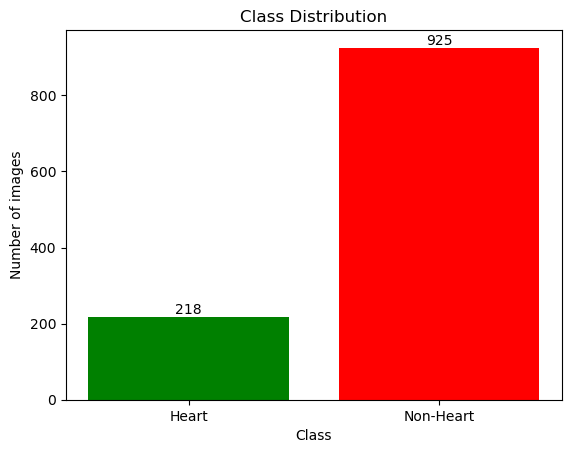

In [5]:
#Reference 8: https://github.com/carlosfmorenog/CMM536_CW_2022/blob/main/CMM536_CWP1%26partofP2_ModelSolution.ipynb
#[Code reference 8]

class_dist_original = pd.Series(targets).value_counts()
# Plot BarChart for each class distribution
bars = plt.bar(class_dist_original.index, class_dist_original.values, color=['red', 'green'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.xticks(range(len(class_dist_original.index)), ['Heart', 'Non-Heart'])
for bar, value in zip(bars, class_dist_original.values):
    plt.text(bar.get_x() + bar.get_width()/2, value, str(value), ha='center', va='bottom')
plt.show()

***4. Split the dataset into training and testing sets (Stratified split).***

In [6]:
x_train, x_test, y_train, y_test = train_test_split(images, targets, test_size=0.2, shuffle=True, stratify=targets)

***5.1. Dataset Classification with a Non-Neural Network, for this part, we have chosen Random Forest Classifier.***

In [7]:
#Reference 2: https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution
#[Code Reference 2]

# Train a random forest classifier
start_time = time.time()
rf = RandomForestClassifier(n_estimators = 3)
rf.fit(x_train, y_train)
end_time = time.time()

***5.2. Display time estimation for RF training execution and compare it later with a neural network model.***

In [8]:
# Get time needed to classify images with RF model
execution_time = end_time - start_time
print(f'Execution time: {execution_time:.6f} seconds')

Execution time: 0.028633 seconds


In [9]:
y_pred_rf = rf.predict(x_test)
rf.score(x_test,y_test)

1.0

***5.3. Confusion Matrix Realisation for RF Model:***

---


***We consider that labels are : 0 for  HEART &  1 for NON_HEART images***

In [10]:
#Reference 3: <https://www.youtube.com/watch?v=jTCkpB7vjRA>
#Kunaal Naik | Data Science Masterminds
#[Code Reference 3]

cm_rf= confusion_matrix(y_test, y_pred_rf,labels=rf.classes_)
print(cm_rf)

[[ 44   0]
 [  0 185]]


Text(0.5, 1.0, 'Confusion matrix for RF model')

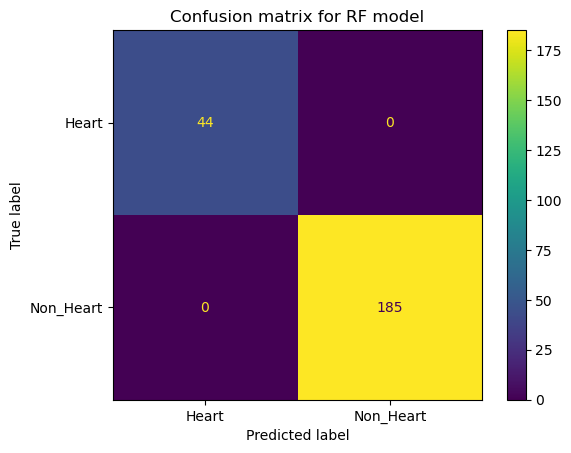

In [11]:
cm_rf_display= ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels = ['Heart', 'Non_Heart'])
cm_rf_display.plot()
plt.title('Confusion matrix for RF model')

***Conclusion of RF Confusion Matrix:***

---



***The confusion matrix shows that the Random Forest classifier correctly identified 44 samples as 'Heart' and 185 samples as 'non_heart'. with null False Negative and False Positive. This leads to the conclusion that this classifier is 100% accurate for both classes during this particular test.***

***5.4. Classification report for RF model:***

In [12]:
#Reference 4: https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/12_precision_recall/12_precision_recall.ipynb
#[Code Reference 4]

# Print the classification report for each classifier
print('\nRandom Forest Classification Report:')
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        44
         1.0       1.00      1.00      1.00       185

    accuracy                           1.00       229
   macro avg       1.00      1.00      1.00       229
weighted avg       1.00      1.00      1.00       229



***Random Forest Classification Report Insights:***

---


***From the Random Forest Classification Report. We corroborate our previous confusion matrix results, which showed that this model performed extraordinarily well, with an overall accuracy of 1.0 and perfect precision, recall, and F1-score scores for both classes. Later, we'll perform K folds stratified validation to determine whether the classifier's performance is consistent and actually correct across multiple dataset test variants.***

***6.1. Datasets Classification with neural network model Convolutional neural network 'CNN':***

In [13]:
#Reference 5: https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/16_cnn_cifar10_small_image_classification/cnn_cifar10_dataset.ipynb
#[Code reference]

def cnn_model():
    cnn = models.Sequential([
        layers.Input(shape=(128, 128, 1)),
        layers.Conv2D(filters= 2, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])
    cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return cnn

In [14]:
cnn = cnn_model()

In [15]:
x_train_cnn = x_train.reshape(-1, 128, 128, 1)
x_test_cnn = x_test.reshape(-1, 128, 128, 1)


***6.2. Display time estimation for CNN model training:***

In [16]:
#[Code reference 2]

start_time = time.time()
cnn.fit(x_train_cnn, y_train, epochs= 8, validation_data=(x_test_cnn, y_test))
end_time = time.time()
execution_time = end_time - start_time
print(f'Execution time: {execution_time:.6f} seconds')

Epoch 1/8
29/29 [==============================] - 2s 37ms/step - loss: 0.0466 - accuracy: 0.9880 - val_loss: 1.4034e-06 - val_accuracy: 1.0000
Epoch 2/8
29/29 [==============================] - 1s 33ms/step - loss: 7.8073e-07 - accuracy: 1.0000 - val_loss: 4.6330e-07 - val_accuracy: 1.0000
Epoch 3/8
29/29 [==============================] - 1s 33ms/step - loss: 4.0041e-07 - accuracy: 1.0000 - val_loss: 3.3837e-07 - val_accuracy: 1.0000
Epoch 4/8
29/29 [==============================] - 1s 33ms/step - loss: 3.1341e-07 - accuracy: 1.0000 - val_loss: 2.8006e-07 - val_accuracy: 1.0000
Epoch 5/8
29/29 [==============================] - 1s 33ms/step - loss: 2.6437e-07 - accuracy: 1.0000 - val_loss: 2.3998e-07 - val_accuracy: 1.0000
Epoch 6/8
29/29 [==============================] - 1s 33ms/step - loss: 2.2929e-07 - accuracy: 1.0000 - val_loss: 2.1343e-07 - val_accuracy: 1.0000
Epoch 7/8
29/29 [==============================] - 1s 34ms/step - loss: 2.0320e-07 - accuracy: 1.0000 - val_loss: 1.

In [17]:
y_pred_cnn = cnn.predict(x_test_cnn)

8/8 [==============================] - 0s 8ms/step


In [18]:
# Convert probabilities to class labels
y_pred_cnn_labels = np.argmax(y_pred_cnn, axis=1)

***6.3.  Confusion Matrix realisation for CNN Model:***

Text(0.5, 1.0, 'Confusion matrix for CNN model')

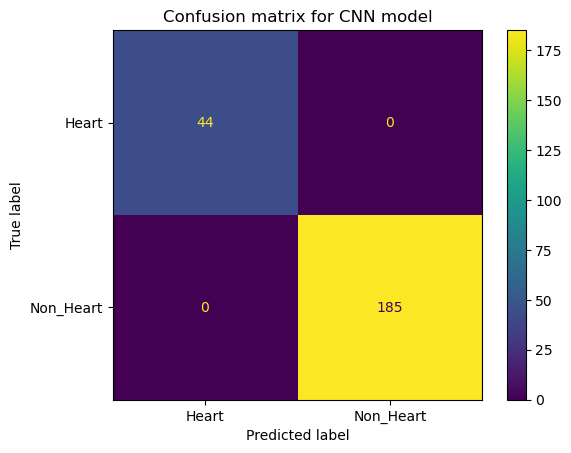

In [19]:
#[Code Reference 3]
cm_cnn = confusion_matrix(y_test, y_pred_cnn_labels)
# Plot the confusion matrix
cm_cnn_display= ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels = ['Heart', 'Non_Heart'])
cm_cnn_display.plot()
plt.title('Confusion matrix for CNN model')

***Observation of the Confusion Matrix for CNN model***

---


***After visualising the CNN model's confusion matrix. This provides useful information and yields the same result as the RF model. We can conclude that the CNN model obtained flawless classification with 100% precision.***


***6.4. Classification report result for CNN model:***

In [20]:
#[Code Reference 4]

print('\nCNN Classification Report:')
print(classification_report(y_test, y_pred_cnn_labels))
##print(classification_report(y_test, y_pred_cnn))


CNN Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        44
         1.0       1.00      1.00      1.00       185

    accuracy                           1.00       229
   macro avg       1.00      1.00      1.00       229
weighted avg       1.00      1.00      1.00       229



***Conclusion***

---
***The report confirms that the CNN model performed flawlessly and validates the previous confusion matrix result. Precision, recall, and F1-score all equaled one for both courses, and overall accuracy was one. As previously said, we need to run K folds stratified on this model to ensure that the performance remains high even if the datasets of Train_Test_splits vary.***

***7. K fold Cross-validation:***

---
***We will apply k-fold cross-validation on both models to confirm their performance and avoid any forms of overfitting.***


In [21]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [22]:
#Reference 6: https://stackoverflow.com/questions/59743430/tensorflow-how-to-get-the-accuracy-of-the-prediction-function-result
#[Code reference 6]

cnn.save('model.h5')

***7.1. 5k Fold Stratified for CNN model:***

In [23]:
def load_cnn_model():
    return models.load_model('model.h5')

In [24]:
kc = KerasClassifier(build_fn=load_cnn_model, epochs=2, batch_size=32, verbose=0)

In [25]:
# Below Code is troubleshoot on ChatGPT with the code modified from below reference:
#https://github.com/codebasics/py/blob/master/ML/12_KFold_Cross_Validation/12_k_fold.ipynb

scores = []
for train_index, val_index in skf.split(x_train, y_train):
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    x_train_fold = x_train_fold.reshape(-1, 128, 128, 1)
    x_val_fold = x_val_fold.reshape(-1, 128, 128, 1)
    cnn.fit(x_train_fold, y_train_fold, epochs=2, verbose=0)
    _, accuracy = cnn.evaluate(x_val_fold, y_val_fold, verbose=0)
    scores.append(accuracy)

In [26]:
mean_score = np.mean(scores)
std_score = np.std(scores)

In [27]:
print('\n5k Fold Stratified result for CNN model:')
print(scores)
print(f'Mean validation accuracy: {mean_score:.4f}')
print(f'Standard deviation of validation accuracy: {std_score:.4f}')


5k Fold Stratified result for CNN model:
[1.0, 1.0, 1.0, 1.0, 1.0]
Mean validation accuracy: 1.0000
Standard deviation of validation accuracy: 0.0000


***7.2. 5k Fold Stratified for RF model:***

In [28]:
#Reference 7: https://github.com/codebasics/py/blob/master/ML/12_KFold_Cross_Validation/12_k_fold.ipynb
rf_scores = cross_val_score(rf, images, targets, cv=5)

In [29]:
print('\n5k Fold Stratified result for RF model:')
print("Scores:", rf_scores)
print("Mean score:", np.mean(rf_scores))


5k Fold Stratified result for RF model:
Scores: [1. 1. 1. 1. 1.]
Mean score: 1.0


***General Conclusion for task 1***

---


***According to prior results, in 5-fold stratified cross-validation, both the CNN and RF models achieved immaculate accuracy across all folds. Also, we have established that RF is faster(Execution time: 0.028 sc) than the CNN model(Execution time: 8.61 sc) and requires fewer computational resources during this dataset classification, and the accuracy provided is ideal for image processing; however, CNN can better peak up and detect patterns and images to make sense of them, especially for larger datasets, even if it is not our case but it is expected to rise in the future in task 3 with data augmentation. Furthermore, the next assignment will require a profound understanding and precision to distinguish between open and closed hearts, which are essentially identical and simple to misinterpret.As previously stated, CNN outperforms RF in this regard.***

***So, for task 2, we prioritise classifier accuracy and performance (CNN) over CPU resources and training time (related to RF model)because we don't have a large number of images (around 200), allowing us to ignore the speed test train split and classifier result obtention.***


# **Task 2:**



---


***For this part, we are going to use the CNN model for image classification of 'open' and 'closed' heart with straightforward 80/20 train/test validation and reflect on the result obtained in terms of precision, recall, f1-score runtime, ROC, and a confusion matrix.***

***1. Data preparation***

In [30]:
#[Code reference 1]
#Preparing Data#
input_path = r'C:\Users\obouk\OneDrive\Bureau\Master RGU\Advanced Data Science_Python\CourseWork\heart'

In [31]:
images= []
targets = []

In [32]:
for t_index, target in enumerate(os.listdir(input_path)):
    path_join= os.path.join(input_path, target)
    for img_name in os.listdir(path_join):
        img_path = os.path.join(path_join, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128,128))
        img_bin = cv2.adaptiveThreshold(img, 255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 13, 2)
        images.append(img_bin.flatten())
        targets.append(t_index)

images = np.asarray(images, dtype="object").astype(np.float32)
## targets is the label index 0 for close_heart and 1 for open-heart
targets = np.asarray(targets, dtype="object").astype(np.float32)
###Preprocess images (normalize pixel values to range [0, 1])
images = images/ 255

***2. BarChart for the distribution of each class:***

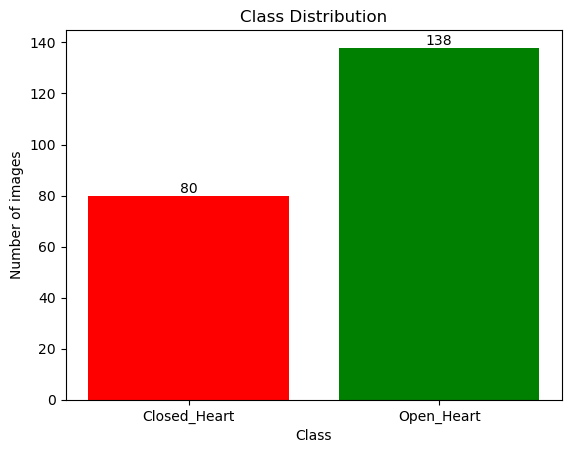

In [33]:
#[Code reference 8]
class_dist_original = pd.Series(targets).value_counts()
# Plot BarChart for each class distribution
bars = plt.bar(class_dist_original.index, class_dist_original.values, color=['green', 'red'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.xticks(range(len(class_dist_original.index)), ['Closed_Heart', 'Open_Heart'])
for bar, value in zip(bars, class_dist_original.values):
    plt.text(bar.get_x() + bar.get_width()/2, value, str(value), ha='center', va='bottom')
plt.show()

***3. Train_Test Dataset and Classify the images with CNN model:***

In [34]:
x_train, x_test, y_train, y_test = train_test_split(images, targets, test_size=0.2, shuffle=True, stratify=targets)

***Note that the CNN model below is utilising one convolutional layer, because after attempting multiple times to raise the accuracy with this factor, this last did not increase at all, and execution time is increasing longer though.***

In [35]:
#[Code Reference 5]
def cnn_model():
    cnn = models.Sequential([
        layers.Input(shape=(128, 128, 1)),
        layers.Conv2D(filters= 2, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])
    cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return cnn

In [46]:
cnn = cnn_model()
x_train_cnn = x_train.reshape(-1, 128, 128, 1)
x_test_cnn = x_test.reshape(-1, 128, 128, 1)
#[Code reference 2]
start_time = time.time()
cnn.fit(x_train_cnn, y_train, epochs= 17, validation_data=(x_test_cnn, y_test))
end_time = time.time()
execution_time = end_time - start_time
print(f'Execution time: {execution_time:.6f} seconds')

Epoch 1/17
6/6 [==============================] - 1s 59ms/step - loss: 1.8753 - accuracy: 0.5115 - val_loss: 0.9232 - val_accuracy: 0.3636
Epoch 2/17
6/6 [==============================] - 0s 36ms/step - loss: 0.8094 - accuracy: 0.6379 - val_loss: 0.8828 - val_accuracy: 0.6364
Epoch 3/17
6/6 [==============================] - 0s 37ms/step - loss: 0.6262 - accuracy: 0.6954 - val_loss: 0.6192 - val_accuracy: 0.6364
Epoch 4/17
6/6 [==============================] - 0s 36ms/step - loss: 0.5488 - accuracy: 0.7471 - val_loss: 0.4203 - val_accuracy: 0.8409
Epoch 5/17
6/6 [==============================] - 0s 37ms/step - loss: 0.4519 - accuracy: 0.7529 - val_loss: 0.4035 - val_accuracy: 0.7727
Epoch 6/17
6/6 [==============================] - 0s 36ms/step - loss: 0.3437 - accuracy: 0.8851 - val_loss: 0.3757 - val_accuracy: 0.9091
Epoch 7/17
6/6 [==============================] - 0s 37ms/step - loss: 0.2899 - accuracy: 0.9368 - val_loss: 0.3179 - val_accuracy: 0.8864
Epoch 8/17
6/6 [===========

***Remarque: The training report result vary each time we re-execute the code and this is due to training data Shuffling between epochs, the model may see the data points in a different order in each run,however it is not affecting considerably our result since the we've almost always an accuracy above 94%.***

In [47]:
y_pred_cnn = cnn.predict(x_test_cnn)

2/2 [==============================] - 0s 4ms/step


In [48]:
# Convert probabilities to class labels
y_pred_cnn_labels = np.argmax(y_pred_cnn, axis=1)

***3. Confusion Matrix visualisation for CNN model on 'OPEN' & 'CLOSED' Heart Class:***

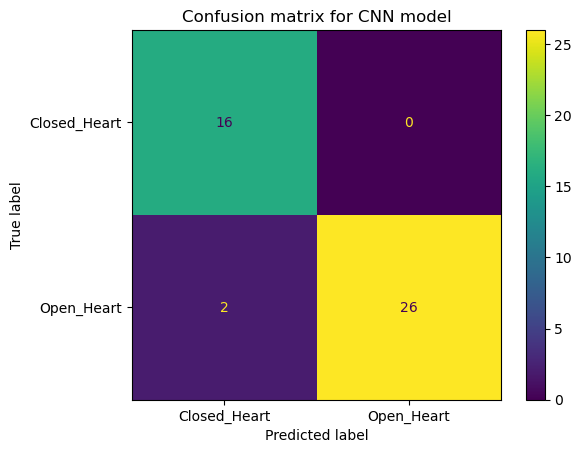

In [49]:
#[Code Reference 3]
cm_cnn = confusion_matrix(y_test, y_pred_cnn_labels)
# Plot the confusion matrix
cm_cnn_display= ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels = ['Closed_Heart', 'Open_Heart'])
cm_cnn_display.plot()
plt.title('Confusion matrix for CNN model')
plt.savefig('confusion_matrix_cnn.png')

***4. CNN Classification Report:***

In [50]:
#[Code Reference 4]
print('\nCNN Classification Report:')
print(classification_report(y_test, y_pred_cnn_labels))
##print(classification_report(y_test, y_pred_cnn))


CNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94        16
         1.0       1.00      0.93      0.96        28

    accuracy                           0.95        44
   macro avg       0.94      0.96      0.95        44
weighted avg       0.96      0.95      0.96        44



***Conclusion***

---


***CNN models can be more prone to overfitting, especially if they have a large number of parameters and are trained on a small dataset. which is our case I've interpreted that 15 epochs is the most appropriate parameter to avoid this phenomenon and get a high accuracy. as shown on the classification report and confusion matrix there's a tiny number of misclassification with 2 errors. and an f1-score of very good with 94%. Note that the performance might vary for different train tests, however,from observing The validation loss for our training, this factor decrease initially, but begins to grow after a specific number of epochs(17 epochs in this case).showing potential overfitting when the model gets overly specialised to the training data.***

***5. Receiver operating characteristic Curve (ROC) Realisation:***

---

***The ROC curve is used to analyse the compromise between FPR and TPR in the context of a classifier system, and it allows for the evaluation and comparison of different classifiers.***

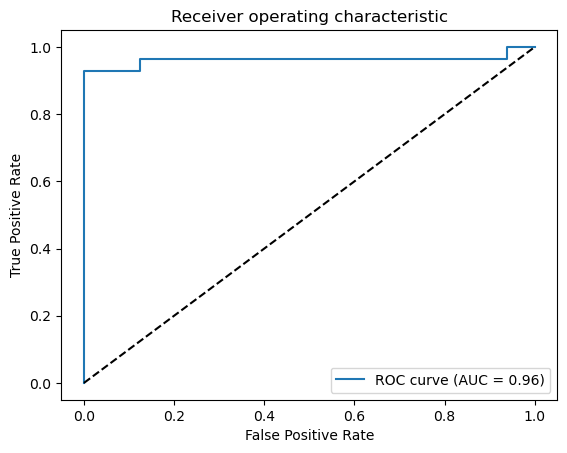

In [51]:
#Reference 9: https://colab.research.google.com/drive/1cqnLIlpLbZ2aFJBB1hvrKJe9vqNI7pen?usp=sharing
from sklearn.metrics import roc_curve, auc
FPR, TPR, thresholds = roc_curve(y_test, y_pred_cnn[:, 1])
AUC = auc(FPR, TPR)
plt.plot(FPR, TPR, label='ROC curve (AUC = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

***General Conclusion***

---


***Based on the analysis of the Receiver Operating Characteristic (ROC) curve, Classification report, and Confusion matrix observation, it is possible to conclude that the CNN model performs extremely well with an Area Under the Curve (AUC) value of 0.96, indicating that this model is highly accurate in predicting and distinguishing between classes (Open and Closed Heart). However, we should highlight that we only have a limited dataset, and further testing with a larger and more diverse dataset may be required to validate the model's performance. Which will try to acheive it in the next part.***

# **Task 3:**

***1. Improve Test Accuracy Using Data Augmentation:***

---
***To generate new samples from our existing datasets ('Open' and 'Closed' Heart). We will employ data augmentation to improve the accuracy of our model. We will transform our images using rotation, horizontal flip, scale, and contrast.***

In [52]:
#Reference 10: https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/17_data_augmentation/cnn_flower_image_classification_data_augmentations.ipynb

#[Code Reference 10]
data_augmentation = keras.Sequential(
  [
    #layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 #input_shape=(img_height, 
                                                              #img_width,
                                                              #1)),
    #layers.experimental.preprocessing.RandomRotation(0.5),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [53]:
#[Code Reference 5]
def cnn_model_da():  
    cnn = models.Sequential([
        data_augmentation,
        layers.Input(shape=(128, 128, 1)),
        layers.Conv2D(filters= 2, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),        
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])
    cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return cnn

In [54]:
cnn_da = cnn_model_da()

#[Code reference 2]
start_time = time.time()
cnn_da.fit(x_train_cnn, y_train, epochs= 17, validation_data=(x_test_cnn, y_test))
end_time = time.time()
execution_time = end_time - start_time
print(f'Execution time: {execution_time:.6f} seconds')

Epoch 1/17
6/6 [==============================] - 2s 63ms/step - loss: 0.7622 - accuracy: 0.5747 - val_loss: 0.5145 - val_accuracy: 0.6364
Epoch 2/17
6/6 [==============================] - 0s 43ms/step - loss: 0.5753 - accuracy: 0.6494 - val_loss: 0.4221 - val_accuracy: 0.7045
Epoch 3/17
6/6 [==============================] - 0s 43ms/step - loss: 0.4266 - accuracy: 0.8218 - val_loss: 0.3080 - val_accuracy: 0.8864
Epoch 4/17
6/6 [==============================] - 0s 43ms/step - loss: 0.3714 - accuracy: 0.8793 - val_loss: 0.2653 - val_accuracy: 0.9091
Epoch 5/17
6/6 [==============================] - 0s 41ms/step - loss: 0.3035 - accuracy: 0.8966 - val_loss: 0.3311 - val_accuracy: 0.9091
Epoch 6/17
6/6 [==============================] - 0s 44ms/step - loss: 0.2979 - accuracy: 0.9023 - val_loss: 0.3231 - val_accuracy: 0.8182
Epoch 7/17
6/6 [==============================] - 0s 41ms/step - loss: 0.2548 - accuracy: 0.8966 - val_loss: 0.2119 - val_accuracy: 0.9318
Epoch 8/17
6/6 [===========

***As Seen, The result from the Training DataSet is very accurate, Next of that we need to evaluate this in a Test Dataset***

In [55]:
print('Test Dataset Accuracy')
cnn.evaluate(x_test_cnn,y_test)

Test Dataset Accuracy
2/2 [==============================] - 0s 7ms/step - loss: 0.2075 - accuracy: 0.9545


[0.20748478174209595, 0.9545454382896423]

In [56]:
y_pred_cnn = cnn.predict(x_test_cnn)
# Convert probabilities to class labels
y_pred_cnn_labels = np.argmax(y_pred_cnn, axis=1)

2/2 [==============================] - 0s 6ms/step


In [57]:
#[Code Reference 4]
print('\nCNN Classification Report:')
print(classification_report(y_test, y_pred_cnn_labels))
##print(classification_report(y_test, y_pred_cnn))


CNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94        16
         1.0       1.00      0.93      0.96        28

    accuracy                           0.95        44
   macro avg       0.94      0.96      0.95        44
weighted avg       0.96      0.95      0.96        44



***Conclusion***
---

***When attempting to improve test accuracy using data augmentation techniques such rotation, flipping, zooming ,Experimenting  with different combinations and parameters to find what works best for our specific data, it reveals that the accuracy have been stayed steady only when the zooming technique is used. The majority of the tests leaded to overfitting or degradation in performance. To avoid overfitting on a limited dataset like in this situation, the model must be relatively simple. However, a simpler model may be unable to properly utilise the augmented data to increase performance.There is a delicate balance between model complexity and dataset size.***

---

In [58]:
for index in range(len(y_pred_cnn)):
    predicted_label = np.argmax(y_pred_cnn[index])
    true_label = int(y_test[index])
    
    if predicted_label == true_label:
        if true_label == 0:
            print('The image', index, 'is accurate and it is a closed heart')
        elif true_label == 1:
            print('The image', index, 'is accurate and it is an open heart')
    else:
        if true_label == 0:
            print('The image', index, 'is open heart but it should be closed heart"FN"')
        elif true_label == 1:
            print('The image', index, 'is closed heart but it should be open heart"FP"')


The image 0 is accurate and it is an open heart
The image 1 is accurate and it is a closed heart
The image 2 is accurate and it is an open heart
The image 3 is accurate and it is a closed heart
The image 4 is accurate and it is an open heart
The image 5 is accurate and it is a closed heart
The image 6 is accurate and it is an open heart
The image 7 is accurate and it is an open heart
The image 8 is accurate and it is an open heart
The image 9 is accurate and it is an open heart
The image 10 is accurate and it is a closed heart
The image 11 is accurate and it is an open heart
The image 12 is accurate and it is an open heart
The image 13 is accurate and it is a closed heart
The image 14 is accurate and it is an open heart
The image 15 is accurate and it is a closed heart
The image 16 is accurate and it is a closed heart
The image 17 is accurate and it is a closed heart
The image 18 is accurate and it is an open heart
The image 19 is closed heart but it should be open heart"FP"
The image 

***The purpose of the results that are demonstrated above is to identify which test_image is correct by comparing it to the image predicted by the (CNN) model. We can check this using the confusion matrix below.***

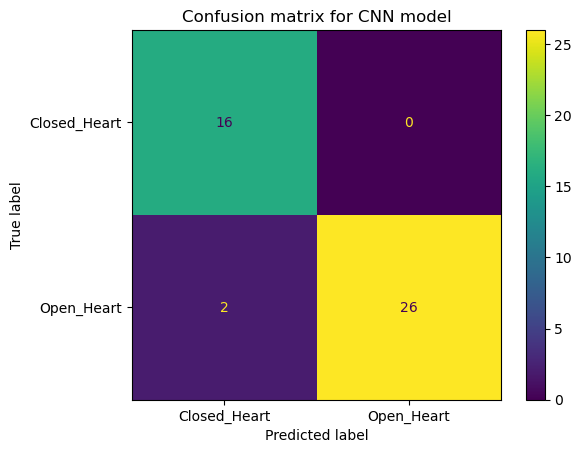

In [59]:
#[Code Reference 3]
cm_cnn = confusion_matrix(y_test, y_pred_cnn_labels)
# Plot the confusion matrix
cm_cnn_display= ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels = ['Closed_Heart', 'Open_Heart'])
cm_cnn_display.plot()
plt.title('Confusion matrix for CNN model')
plt.savefig('confusion_matrix_cnn.png')

***2. Improve Test Accuracy Using Transfer Learning and data augmentation:***

In [69]:
#Reference 11: https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/18_transfer_learning/cnn_transfer_learning.ipynb
#Reference 12:https://colab.research.google.com/drive/19g5upxxkOiEAgj6TFyDmCXwYpQbGLdQx?usp=sharing#scrollTo=O23RX4RAVCsI
#[Code Reference 11]
#[Code Reference 5]

def cnn_model_transfer_learning():
    inputs = layers.Input(shape=(128, 128, 3))
    x = data_augmentation(inputs)

    #x = inputs
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=x)
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    predictions = layers.Dense(2, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [70]:
cnn_tl = cnn_model_transfer_learning()
x_train_cnn_tl = x_train.reshape(-1, 128, 128, 1).repeat(3, axis=-1)
x_test_cnn_tl = x_test.reshape(-1, 128, 128, 1).repeat(3, axis=-1)

start_time = time.time()
cnn_tl.fit(x_train_cnn_tl, y_train, epochs=17, validation_data=(x_test_cnn_tl, y_test))
end_time = time.time()
execution_time = end_time - start_time
print(f'Execution time: {execution_time:.6f} seconds')

Epoch 1/17
6/6 [==============================] - 8s 1s/step - loss: 0.6863 - accuracy: 0.5517 - val_loss: 0.5985 - val_accuracy: 0.6364
Epoch 2/17
6/6 [==============================] - 5s 809ms/step - loss: 0.5975 - accuracy: 0.7586 - val_loss: 0.5640 - val_accuracy: 0.8636
Epoch 3/17
6/6 [==============================] - 5s 824ms/step - loss: 0.5278 - accuracy: 0.7701 - val_loss: 0.5129 - val_accuracy: 0.7045
Epoch 4/17
6/6 [==============================] - 5s 841ms/step - loss: 0.5140 - accuracy: 0.7299 - val_loss: 0.4736 - val_accuracy: 0.7955
Epoch 5/17
6/6 [==============================] - 5s 819ms/step - loss: 0.4637 - accuracy: 0.7931 - val_loss: 0.4501 - val_accuracy: 0.8182
Epoch 6/17
6/6 [==============================] - 5s 781ms/step - loss: 0.4345 - accuracy: 0.7701 - val_loss: 0.4287 - val_accuracy: 0.7955
Epoch 7/17
6/6 [==============================] - 5s 772ms/step - loss: 0.4265 - accuracy: 0.7874 - val_loss: 0.4203 - val_accuracy: 0.8636
Epoch 8/17
6/6 [=======

In [71]:
print('Test Dataset Accuracy using TL and DA')
cnn_tl.evaluate(x_test_cnn_tl,y_test)

Test Dataset Accuracy using TL and DA
2/2 [==============================] - 1s 254ms/step - loss: 0.2821 - accuracy: 0.9318


[0.2821144163608551, 0.9318181872367859]

In [72]:
y_pred_cnn_tl = cnn_tl.predict(x_test_cnn_tl)
# Convert probabilities to class labels
y_pred_cnn_labels_tl = np.argmax(y_pred_cnn_tl, axis=1)

2/2 [==============================] - 2s 273ms/step


In [73]:
#[Code Reference 4]
print('\nCNN Classification Report with Data augmentation and transfer learning:')
print(classification_report(y_test, y_pred_cnn_labels_tl))
##print(classification_report(y_test, y_pred_cnn))


CNN Classification Report with Data augmentation and transfer learning:
              precision    recall  f1-score   support

         0.0       0.93      0.88      0.90        16
         1.0       0.93      0.96      0.95        28

    accuracy                           0.93        44
   macro avg       0.93      0.92      0.93        44
weighted avg       0.93      0.93      0.93        44



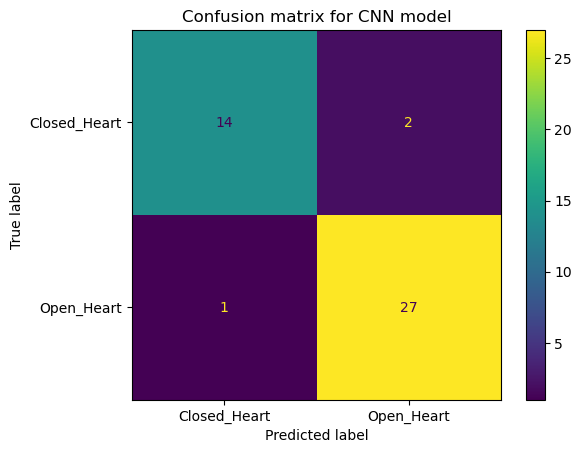

In [74]:
#[Code Reference 3]
cm_cnn = confusion_matrix(y_test, y_pred_cnn_labels_tl)
# Plot the confusion matrix
cm_cnn_display= ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels = ['Closed_Heart', 'Open_Heart'])
cm_cnn_display.plot()
plt.title('Confusion matrix for CNN model')
plt.savefig('confusion_matrix_cnn.png')

***General Conclusion*** 
---
***The accuracy resulted from the classification report on CNN model using data augmentation and transfer learning methods is slightly lower than the CNN model alone with 93%, but it still has good accuracy, several factors can contribute to that, especially with a small dataset size, which as previously mentioned, we need to balance model complexity. Transfer learning introduces additional trainable parameters to the model, increasing the risk of overfitting.***

***3. Improving Test Accuracy Using segmentation algorithm U.NET:***

In [79]:
#Reference: https://www.youtube.com/watch?v=IHq1t7NxS8k
#Reference: https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/13_dropout_layer/dropout_regularization_ann.ipynb

input_path = r'C:\Users\obouk\OneDrive\Bureau\Master RGU\Advanced Data Science_Python\CourseWork\Task3\heart'
mask_path = r'C:\Users\obouk\OneDrive\Bureau\Master RGU\Advanced Data Science_Python\CourseWork\Task3\masks'

heart_images = []
annotated_masks = []

for img_name in os.listdir(input_path):
    img_path = os.path.join(input_path, img_name)
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask_name = img_name
    
    mask_img_path = os.path.join(mask_path, mask_name)
    mask = cv2.imread(mask_img_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Skipping {img_name}: Mask image could not be loaded.")
        continue
    if img.shape != mask.shape:
        print(f"Skipping {img_name} and {mask_name}: Image and mask shapes are not consistent.")
        continue
    heart_images.append(img)
    annotated_masks.append(mask)
heart_images = np.asarray(heart_images).astype(np.float32)
annotated_masks = np.asarray(annotated_masks).astype(np.float32)

heart_images = heart_images / 255
annotated_masks = annotated_masks / 255

heart_images = heart_images.reshape((-1, 128, 128, 1))
annotated_masks = annotated_masks.reshape((-1, 128, 128, 1))
x_train, x_test, y_train, y_test = train_test_split(heart_images, annotated_masks, test_size=0.2, random_state=42)
data_augmentation = keras.Sequential(
    [
        #layers.experimental.preprocessing.RandomFlip("horizontal"),
        #layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

# Define UNet model with increased complexity and dropout regularization
def unet_model(optimizer='adam'):
    inputs = keras.Input(shape=(128, 128, 1))
    
    augmented_inputs = data_augmentation(inputs)
    
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(augmented_inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = layers.BatchNormalization()(pool1)
    
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = layers.BatchNormalization()(pool2)
    
    # Decoder
    up1 = layers.UpSampling2D(size=(2, 2))(pool2)
    up1 = layers.concatenate([conv2, up1], axis=3)
    up1 = layers.BatchNormalization()(up1)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up1)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    
    up2 = layers.UpSampling2D(size=(2, 2))(conv3)
    up2 = layers.concatenate([conv1, up2], axis=3)
    up2 = layers.BatchNormalization()(up2)
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up2)
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv4)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1_score'])
    return model


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    return 2 * ((precision_value * recall_value) / (precision_value + recall_value + K.epsilon()))

precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()
f1_score_metric = f1_score
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[precision_metric, recall_metric, f1_score_metric])

# Train the model
start_time = time.time()
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
end_time = time.time()
execution_time = end_time - start_time
print(f'Execution time: {execution_time:.6f} seconds')

Epoch 1/10
6/6 [==============================] - 72s 11s/step - loss: 0.5988 - precision_1: 0.3556 - recall_1: 0.2612 - f1_score: 0.1406 - val_loss: 0.4780 - val_precision_1: 0.7865 - val_recall_1: 0.0167 - val_f1_score: 0.0184
Epoch 2/10
6/6 [==============================] - 67s 11s/step - loss: 0.2893 - precision_1: 0.8863 - recall_1: 0.1484 - f1_score: 0.2709 - val_loss: 0.3979 - val_precision_1: 0.8715 - val_recall_1: 0.0448 - val_f1_score: 0.0655
Epoch 3/10
6/6 [==============================] - 66s 11s/step - loss: 0.2528 - precision_1: 0.9087 - recall_1: 0.2290 - f1_score: 0.4126 - val_loss: 0.3683 - val_precision_1: 0.8261 - val_recall_1: 0.0642 - val_f1_score: 0.0958
Epoch 4/10
6/6 [==============================] - 67s 11s/step - loss: 0.2264 - precision_1: 0.9354 - recall_1: 0.2833 - f1_score: 0.4904 - val_loss: 0.3539 - val_precision_1: 0.7045 - val_recall_1: 0.0787 - val_f1_score: 0.1210
Epoch 5/10
6/6 [==============================] - 66s 11s/step - loss: 0.2122 - prec

In [82]:
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(np.float32)
y_test_binary = (y_test > 0.5).astype(np.float32)
print('Classification report using U.NET:')
print(classification_report(y_test_binary.flatten(), y_pred_binary.flatten()))


2/2 [==============================] - 3s 841ms/step
Classification report using U.NET:
              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93    626246
         1.0       0.80      0.03      0.07     94650

    accuracy                           0.87    720896
   macro avg       0.84      0.52      0.50    720896
weighted avg       0.86      0.87      0.82    720896



***After executing the segmentation algorithm U.NET, we concluded that the model obtained an accuracy of 87%, which is satisfactory.***


***Final Conclusion*** 

---
***To summarise, based on the results of various model training, we can progressively change several factors in order to marginally improve the performance of our training model (CNN model). In summary, the CNN classification model exceeds the U-Net segmentation algorithm in terms of execution time, which is significantly higher, as well as accuracy.This could be owing to the smaller dataset size, where the U-Net segmentation algorithm might struggle compared to the CNN classifier, which may perform better because to its capacity to generalise patterns despite small data. Also, keep the model simple to avoid overfitting, which was a major issue in our investigation.***

***Thank You!*** 

In [93]:
import io
from nbformat import current

filepath = 'coursework.ipynb' #this is the name of your coursework file!

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'ipynb')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print(word_count)

647
